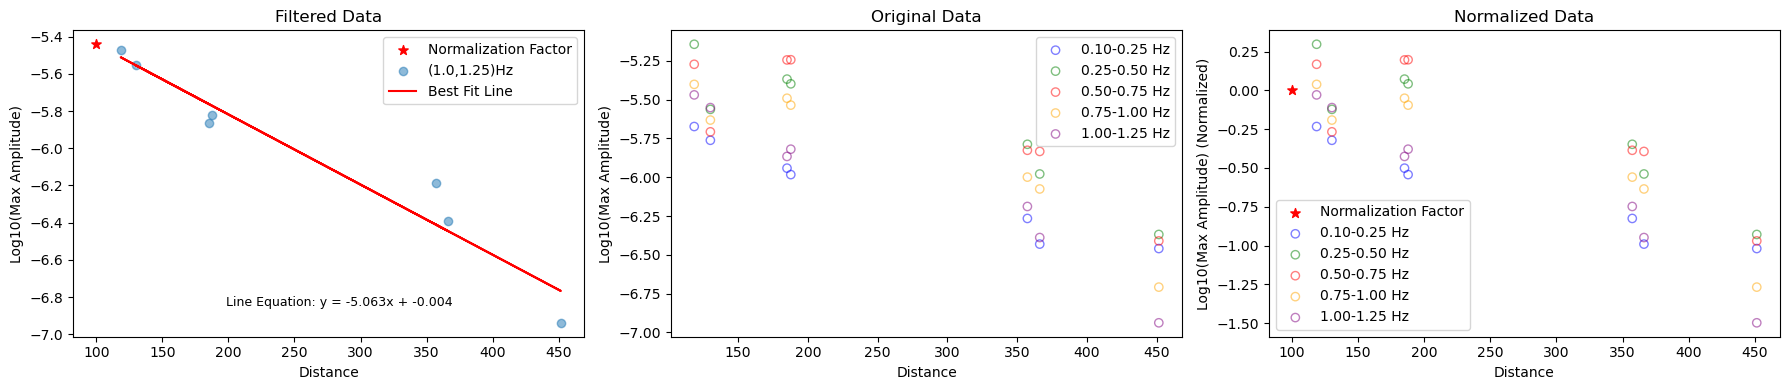

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pickle  # Import the pickle module

def normalize_max_amplitude(row, normalization_factor):
    #THIS IS SUBTRACTING BECAUSE LOGS
    return np.log10(row['max amplitude']) - normalization_factor 
        
def normalization():
    
    # Load the original DataFrame from the pickle file
    with open('Results.pkl', 'rb') as pkl_file:
        original_dataframe = pickle.load(pkl_file)

    # outlier removal

    # Calculate Z-scores for log-transformed max amplitude data
    z_scores = np.abs(stats.zscore(np.log(original_dataframe['max amplitude'])))

    # Set a threshold for outlier detection (e.g., Z-score greater than 3)
    threshold = 3

    # Remove outliers based on the threshold
    outlier_removed_df = original_dataframe[(z_scores < threshold)]

    # Filter only the frequency band (1.0, 1.25) as a reference
    filtered_dataframe = outlier_removed_df[outlier_removed_df['frequency band'] == (1.0, 1.25)]

# normalization factor

    # Calculate the best fit line for the log-transformed filtered data
    filtered_distance = filtered_dataframe['distance']
    filtered_max_amplitude = filtered_dataframe['max amplitude']
    filtered_log_max_amplitude = np.log10(filtered_dataframe['max amplitude'])
    filtered_coefficients = np.polyfit(filtered_distance, filtered_log_max_amplitude, 1)
    filtered_best_fit_line = np.poly1d(filtered_coefficients)

    # Calculate the normalization factor (max amps) at a distance of 500 using the best-fit line
    normalizeBench = 100
    normalization_factor = filtered_best_fit_line(normalizeBench)
    #print(filtered_best_fit_line(500))
    
    # Create a new DataFrame for the normalized data
    normalized_dataframe = outlier_removed_df.copy()

    # Apply the normalization function to create the 'max amplitude (normalized)' column
    normalized_dataframe['max amplitude (normalized)'] = normalized_dataframe.apply(lambda row: normalize_max_amplitude(row, normalization_factor), axis=1)

    # Save the normalized DataFrame to a pkl file
    normalized_dataframe.to_pickle('normalized.pkl')

    # Plot the log-transformed original data
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))  # Use sharey=True
    #axs[1].sharey(axs[2])
    
    # Subplot 1: Filtered data with best fit line
    star_x = normalizeBench
    star_y = filtered_best_fit_line(star_x)
    axs[0].scatter(star_x, star_y, color='red', marker='*', s=50, label='Normalization Factor')
    
    axs[0].scatter(filtered_distance, filtered_log_max_amplitude, marker='o', label='(1.0,1.25)Hz', alpha=0.5)
    axs[0].plot(filtered_distance, filtered_best_fit_line(filtered_distance), color='red', label='Best Fit Line')
    axs[0].set_title('Filtered Data')
    axs[0].set_xlabel('Distance')
    axs[0].set_ylabel('Log10(Max Amplitude)')
    
    # Add equation of the line as a text annotation (adjust position)
    equation = f'Line Equation: y = {filtered_best_fit_line[0]:.3f}x + {filtered_best_fit_line[1]:.3f}'
    axs[0].text(0.30, 0.10, equation, transform=axs[0].transAxes, fontsize=9)  # Adjust position here
    axs[0].legend()

    # Subplot 2: Original data with different colors for each frequency band (excluding 1.0,1.25 Hz)
    color_mapping = {
        (0.10, 0.25): 'blue',
        (0.25, 0.50): 'green',
        (0.50, 0.75): 'red',
        (0.75, 1.00): 'orange',
        (1.00, 1.25): 'purple',
    }
    for freq_range, group in normalized_dataframe.groupby('frequency band'):
        color = color_mapping[tuple(freq_range)]
        axs[1].scatter(group['distance'], np.log10(group['max amplitude']), marker='o', facecolors='none', alpha=0.5, label=f'{freq_range[0]:.2f}-{freq_range[1]:.2f} Hz', color=color)
    axs[1].set_title('Original Data')
    axs[1].set_xlabel('Distance')
    axs[1].set_ylabel('Log10(Max Amplitude)')
    axs[1].legend()

    # Subplot 3: Normalized data with different colors for each frequency band (including 1.0,1.25 Hz)
    
    star_x = normalizeBench
    star_y = filtered_best_fit_line(star_x) - filtered_best_fit_line(star_x)
    axs[2].scatter(star_x, star_y, color='red', marker='*', s=50, label='Normalization Factor')
    
    for freq_range, group in normalized_dataframe.groupby('frequency band'):
        color = color_mapping[tuple(freq_range)]
        axs[2].scatter(group['distance'], group['max amplitude (normalized)'], marker='o', facecolors='none', alpha=0.5, label=f'{freq_range[0]:.2f}-{freq_range[1]:.2f} Hz', color=color)
    axs[2].set_title('Normalized Data')
    axs[2].set_xlabel('Distance')
    axs[2].set_ylabel('Log10(Max Amplitude) (Normalized)')
    axs[2].legend()
    image3 = plt.savefig("FinalPlot.png")
    plt.tight_layout()
    plt.show()

    return normalized_dataframe

# call functions
normalized_dataframe = normalization()